In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [4]:
img = cv.imread('images/cameraman.jpg', 0).astype(np.float32) / 255.0

In [5]:
def motion_blur_psf(length, angle):
    psf = np.zeros((length, length))
    center = length // 2
    for i in range(length):
        psf[center, i] = 1
    psf = cv.warpAffine(psf, cv.getRotationMatrix2D((center, center), angle, 1.0), (length, length))
    return psf / psf.sum()

psf = motion_blur_psf(10, 60)

In [6]:
blurred_img = convolve2d(img, psf, mode='same', boundary='wrap')

In [7]:
noise = np.random.normal(0, np.sqrt(0.01), img.shape)
noisy_img = blurred_img + noise

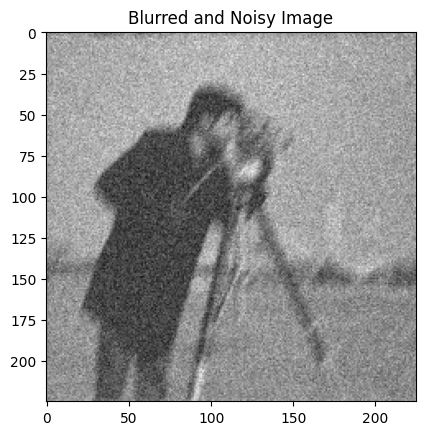

In [8]:
plt.imshow(noisy_img, cmap='gray')
plt.title("Blurred and Noisy Image")
plt.show()

In [9]:
def wiener_deconvolution(img, psf, K=0.01):
    psf_fft = np.fft.fft2(psf, s=img.shape)
    img_fft = np.fft.fft2(img)
    psf_fft_conj = np.conj(psf_fft)
    deconvolved_fft = (psf_fft_conj / (np.abs(psf_fft)**2 + K)) * img_fft
    return np.abs(np.fft.ifft2(deconvolved_fft))

restored_img = wiener_deconvolution(noisy_img, psf)


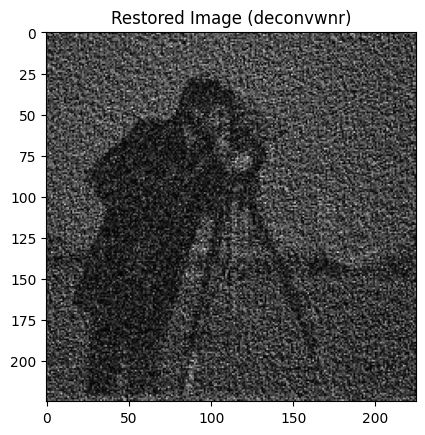

In [10]:
plt.imshow(restored_img, cmap='gray')
plt.title("Restored Image (deconvwnr)")
plt.show()


In [11]:
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr

# محاسبه معیارها
mse_restored = mse(img, restored_img)
snr_restored = psnr(img, restored_img)

print(f"MSE (Restored): {mse_restored}")
print(f"SNR (Restored): {snr_restored} dB")


MSE (Restored): 0.13951556688011205
SNR (Restored): 8.553773319391212 dB


C:\Users\BITA\AppData\Local\Temp\ipykernel_19128\2186809454.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  snr_restored = psnr(img, restored_img)


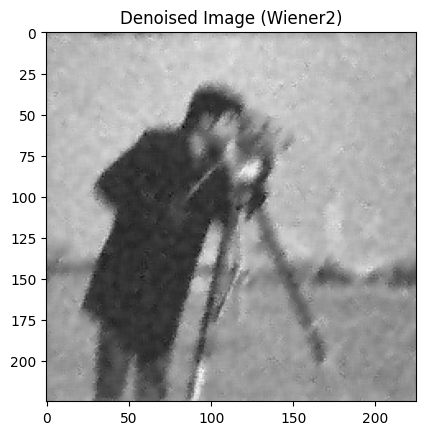

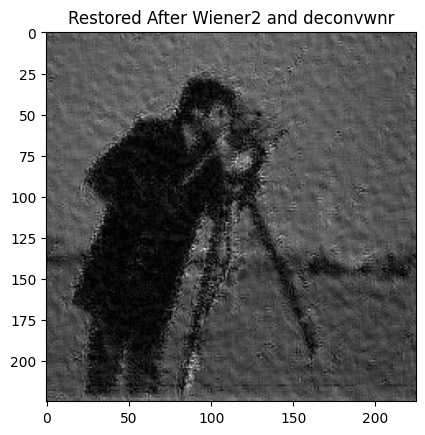

In [12]:
from scipy.ndimage import uniform_filter


def wiener2(img, kernel_size):
    local_mean = uniform_filter(img, size=kernel_size)
    local_mean_sq = uniform_filter(img**2, size=kernel_size)
    local_var = local_mean_sq - local_mean**2
    noise_var = 0.01  # فرض واریانس نویز
    return local_mean + ((np.maximum(local_var - noise_var, 0)) / (local_var + 1e-10)) * (img - local_mean)


denoised_img = wiener2(noisy_img, kernel_size=5)

# نمایش تصویر حذف نویز شده
plt.imshow(denoised_img, cmap='gray')
plt.title("Denoised Image (Wiener2)")
plt.show()

# ترمیم تصویر با deconvwnr پس از حذف نویز Wiener2
restored_after_wiener = wiener_deconvolution(denoised_img, psf)

# نمایش تصویر نهایی
plt.imshow(restored_after_wiener, cmap='gray')
plt.title("Restored After Wiener2 and deconvwnr")
plt.show()


In [13]:

mse_final = mse(img, restored_after_wiener)
snr_final = psnr(img, restored_after_wiener)

print(f"MSE (Final): {mse_final}")
print(f"SNR (Final): {snr_final} dB")

print("\nComparison:")
print(f"MSE Improvement: {mse_restored - mse_final}")
print(f"SNR Improvement: {snr_final - snr_restored} dB")


MSE (Final): 0.03446950163336933
SNR (Final): 14.625649956591342 dB

Comparison:
MSE Improvement: 0.10504606524674272
SNR Improvement: 6.0718766372001305 dB


C:\Users\BITA\AppData\Local\Temp\ipykernel_19128\525278707.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  snr_final = psnr(img, restored_after_wiener)
